# Gazave et al. 2014 two-site frequency spectra

D. P. Rice
3/15/18

# Introduction

The purpose of this notebook is to calculate a quick-and-dirty version of the coarse-grained two-site frequency spectrum. With no missing data, we would start with the genotype of every sample at every site, including monomorphic sites. In fact, what we have is:
1. the start and end points of 15 target regions, totaling 216 Kb
2. the locations of 1,834 SNVs that passed some quality filtering
3. the called genotypes of almost all samples at each SNV.

We also know the number of sites per region that have 1 and 450 samples covered at 20x, but this data is probably too coarse to use, so we'll ignore it here.

We do not know:
1. which sites are confidently monomorphic vs. variants that were filtered
2. which genotypes were masked at each site by the "individual genotype filters" step.

We will proceed by assuming:
1. all sites in target regions that are not called variants are monomorphic
2. all genotypes that are contribute to the "AC" and "AN" fields in the vcf file are good enough to use.

The other overall decision to make is about downsampling. It is common when calculating the SFS to "downsample" each site to a fixed sample size using the hypergeometric expectation. Here, because we are coarse graining the two-site frequency spectrum, we don't need to report the number of snps that are singletons, doubletons, etc., only the number above or below a particular frequency. Thus, we'll just use the minor allele frequency directly from the vcf file. Because most sites have almost all genotypes reported, this decision shouldn't effect things much and it saves us from having to make choices about whether to downsample per site or per pair of sites.

# Setting up the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
targets = pd.read_table('../data/GazaveEtal/gazave_targets.txt', delim_whitespace=True, thousands=',')
targets.head()

,chr,start,end,length,n20x_1_indiv,n20x_450_indiv,nSNVs
0,1,237146097,237165997,19900,19902,19764,180
1,1,237360801,237380801,20000,20004,19539,197
2,4,164000000,164020000,20000,17962,16117,96
3,4,164115673,164135673,20000,19768,19443,119
4,6,165342001,165355001,13000,11098,10659,86


In [3]:
snvs = pd.read_table('../data/GazaveEtal/variants.txt', delim_whitespace=True)
# Rename chromosome labels
snvs.CHROM = snvs.CHROM.apply(lambda s: int(s[3:]))
snvs.head()

,CHROM,POS,REF,ALT,AN,AC,AF
0,7,49565781,C,A,984,9,0.0091
1,7,49565844,G,A,984,1,0.0010
2,7,49565865,C,A,984,1,0.0010
3,7,49566127,G,A,984,356,0.3618
4,7,49566144,T,C,984,1,0.0010


Figure out which SNVs are in which targets. Save as columns.

In [8]:
for index, row in targets.iterrows():
    snvs['in_target{}'.format(index)] = (snvs.CHROM==row.chr) & (snvs.POS >= row.start) & (snvs.POS < row.end)

# Target-level analysis

We'll start by doing only the coarsest analysis: by target region. 

In [129]:
freq_cutoff = 0.01
lohi = 0
for i in range(15):
    snv0 = snvs[snvs['in_target{}'.format(i)]]
    hi = (snv0.AF > freq_cutoff).sum() / targets.length[i]
    lo = (snv0.AF <= freq_cutoff).sum() / targets.length[i]
    print('{:5d}\t{:.4f} {:.4f}'.format(targets.length[i], lo, hi))
    lohi += lo*hi
lohi /= 15
print(lohi)

print((snvs.AF <= freq_cutoff).sum() / targets.length.sum())
print((snvs.AF > freq_cutoff).sum() / targets.length.sum())

lo_tot = (snvs.AF <= freq_cutoff).sum() / targets.length.sum()
hi_tot = (snvs.AF > freq_cutoff).sum() / targets.length.sum()
print(lo_tot*hi_tot)

print(np.log2(lohi/(lo_tot*hi_tot)))

19900	0.0051 0.0040
20000	0.0061 0.0037
20000	0.0027 0.0021
20000	0.0044 0.0015
13000	0.0032 0.0035
12000	0.0048 0.0037
12000	0.0053 0.0048
14000	0.0041 0.0041
14000	0.0075 0.0048
20000	0.0042 0.0022
 8000	0.0051 0.0047
20000	0.0039 0.0027
 7000	0.0073 0.0043
11000	0.0053 0.0054
 5340	0.0067 0.0139
2.39630267941e-05
0.00480947095819
0.00367184609693
1.76596371661e-05
0.440354446138


The log ratio is very positive. This is troubling.

# MISC

As a test, start by only considering the first target.

In [19]:
from scipy.spatial.distance import pdist, squareform

In [17]:
pos = np.array(snvs.POS[snvs.in_target0])
dist = pdist(pos[:,None], p=1)

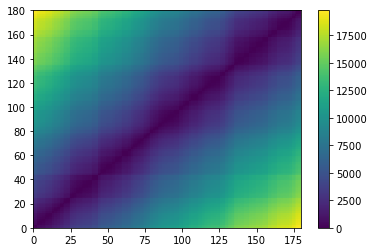

In [24]:
plt.pcolor(squareform(dist))
plt.colorbar()

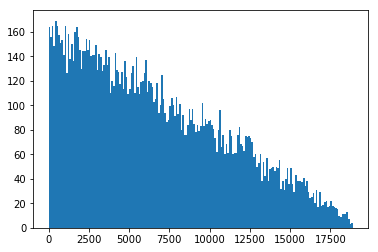

In [27]:
plt.hist(dist, bins=np.arange(0,19000,100));

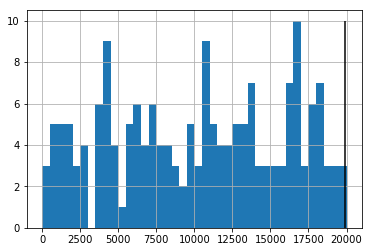

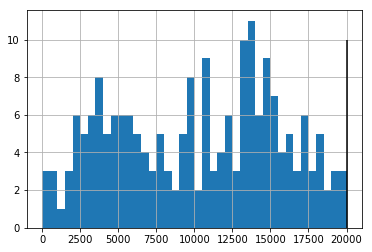

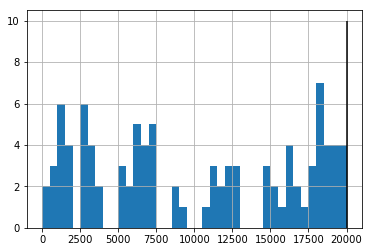

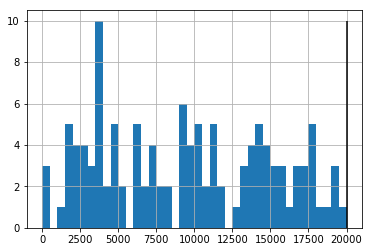

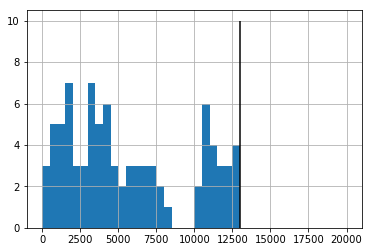

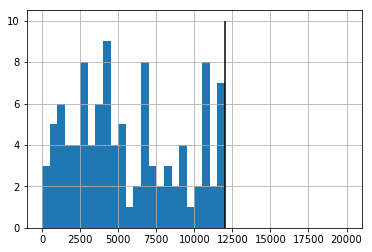

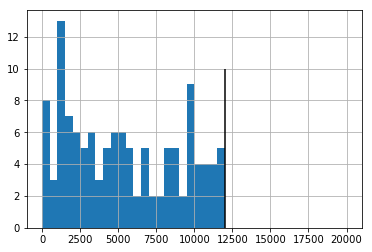

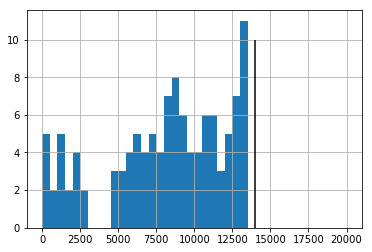

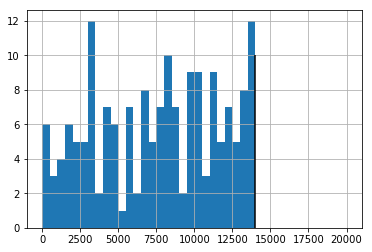

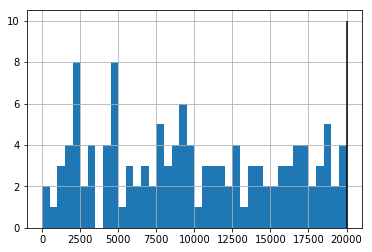

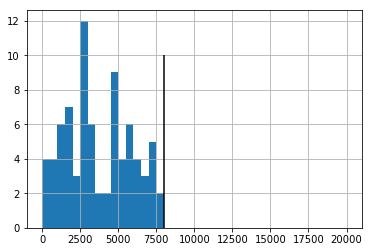

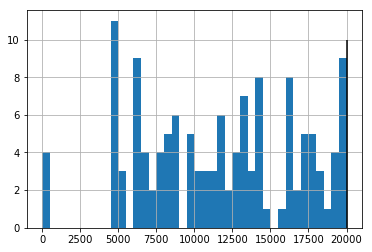

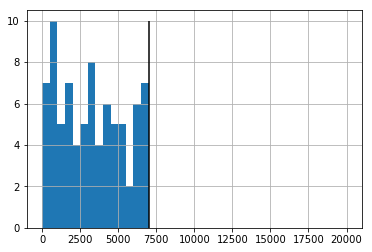

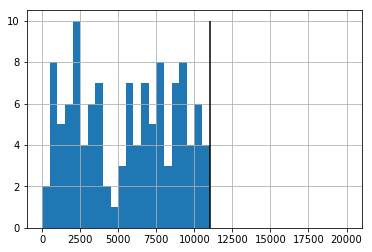

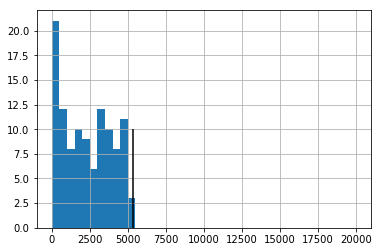

In [37]:
for i in range(15):
    (snvs.POS[snvs['in_target{}'.format(i)]] - targets.start[i]).hist(bins=np.arange(0,20500,500))
    plt.vlines(targets.length[i],0,10)
    plt.show()

In [40]:
(targets.nSNVs / targets.length).describe()

count    15.000000
mean      0.009403
std       0.003796
min       0.004800
25%       0.006583
50%       0.009045
75%       0.010402
max       0.020599
dtype: float64

In [69]:
#has_snv = np.zeros(targets.length[0]//100)
dw = 1000
bins = np.arange(0, targets.length[1]+dw, dw)
binned_counts = np.histogram((snvs.POS[snvs.in_target1]) - targets.start[1], bins=bins)[0]

In [70]:
y = binned_counts - np.mean(binned_counts)

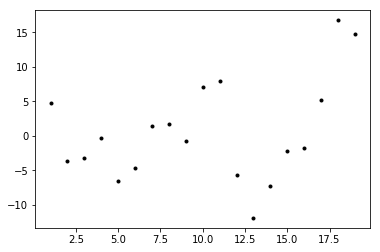

In [71]:
for d in range(1, 20):
    plt.plot(d, np.mean(y[d:]*y[:-d]), 'k.')